# Set up wind farm run

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['./submods/amr-wind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline
cwd              = os.getcwd()

In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
# Location of precursor run with boundary data
precursordir  = '../02_precursor_shell/neutral_8.6at150.10dTInv_0.75z0_750zi_10x7x1km_feb3/'
precursorsetup= os.path.join(precursordir, 'setup_precursor_neutral.i')

# Location of farm run dir
farmrundir       = os.path.join(cwd, 'demo_case')
outputfile       = 'demo_case.inp'
noturboutputfile = 'demo_case_noturbs.inp'

verbose          = True

# Go to the run directory
os.chdir(cwd)
if not os.path.exists(farmrundir):
    os.makedirs(farmrundir)
os.chdir(farmrundir)

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict([('incflo.delp', '0.  0.  0.'),
             ('CoriolisForcing.turn_off_vertical_force', 'True')])

In [4]:
tstart = 20000 #chk65000 16125
tstop  = 21800
textra = 0

In [5]:
# Set the time constants
case.setAMRWindInput('time.stop_time', tstop+textra)
case.setAMRWindInput('time.fixed_dt', 0.02)
case.setAMRWindInput('time.max_step',  -1)

In [6]:
# Set the restart point
chkdir = precursordir+'/chk40000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [7]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics60000.nc'
tavg        =  [tstart, tstop]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
inflowplanes= ['xlo'] #['ylo', 'xhi']
bndryfiles  = os.path.join(precursordir, 'bndry_file.nc')

In [8]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes,
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '../02_precursor_shell/neutral_8.6at150.10dTInv_0.75z0_750zi_10x7x1km_feb3/bndry_file.nc'
SET ABL_bndry_planes = ['xlo']
SET is_periodicx = False
SET xlo_type = 'mass_inflow'
SET xlo_density = 1.225
SET xlo_temperature = 0.0
SET xlo_tke = 0.0
SET xhi_type = 'pressure_outflow'
SET xhi_density = None
SET xhi_temperature = None
SET xhi_tke = None
FILE ../02_precursor_shell/neutral_8.6at150.10dTInv_0.75z0_750zi_10x7x1km_feb3//post_processing/abl_statistics60000.nc does not exist -- setting body force to zero
SET BodyForce = True
SET BodyForce_magnitude = [0.0, 0.0, 0.0]
SET ABLForcing = False
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'


In [9]:
# Add the turbine specifications flag
## Note that the options field can have things like:
##    ADparam_TwrAero:False ADparam_TwrShadow:0 FSTparam_TMax:181234.0
OFoptions=("ADparam_TwrAero:True ADparam_TwrShadow:0 FSTparam_CompHydro:0 FSTparam_CompSub:0 "
           "EDparam_YawDOF:False "
           "EDparam_PtfmSgDOF:False "
           "EDparam_PtfmSwDOF:False "
           "EDparam_PtfmHvDOF:False "
           "EDparam_PtfmRDOF:False "
           "EDparam_PtfmPDOF:False "
           "EDparam_PtfmYDOF:False "           
          )

#"EDparam_RotSpeed:5.00 "

## To specify changes to the OpenFAST model
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T1A, 12, -2000, IEA15MW_ALM, 250.0, , {OFoptions}
T2A, 1862, -2000, IEA15MW_ALM, 250.0, , {OFoptions}
T3A, 3712, -2000, IEA15MW_ALM, 260.0, , {OFoptions}
T4A, 5562, -2000, IEA15MW_ALM, 270.0, , {OFoptions}
#T5A, 7412, -2000, IEA15MW_ALM, 270.0, , {OFoptions}
T1B, 12, 0, IEA15MW_ALM, 250.0, , {OFoptions}
T2B, 1862, 0, IEA15MW_ALM, 250.0, , {OFoptions}
T3B, 3712, 0, IEA15MW_ALM, 260.0, , {OFoptions}
T4B, 5562, 0, IEA15MW_ALM, 270.0, , {OFoptions}
#T5B, 7412, 0, IEA15MW_ALM, 270.0, , {OFoptions}
T1C, 12, 2000, IEA15MW_ALM, 250.0, , {OFoptions}
T2C, 1862, 2000, IEA15MW_ALM, 250.0, , {OFoptions}
T3C, 3712, 2000, IEA15MW_ALM, 260.0, , {OFoptions}
T4C, 5562, 2000, IEA15MW_ALM, 270.0, , {OFoptions}
#T5C, 7412, 2000, IEA15MW_ALM, 270.0, , {OFoptions}
""".format(OFoptions=OFoptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [10]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

case.turbines_createAllTurbines()

docopy = True from /Users/mhenryde/exawind/source/wind-farm-demonstration/submods/amr-wind-frontend/turbines/OpenFAST3p4_IEA15MW to T1A_OpenFAST3p4_IEA15MW
copy /Users/mhenryde/exawind/source/wind-farm-demonstration/submods/amr-wind-frontend/turbines/OpenFAST3p4_IEA15MW failed
T1A_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0)])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /Users/mhenryde/exawind/source/wind-farm-demonstration/submods/amr-wind-frontend/turbines/OpenFAST3p4_IEA15MW to T2A_OpenFAST3p4_IEA15MW
copy /Users/mhenryde/exawind/source/wind-farm-demonstration/submods/amr-wind-frontend/turbines/OpenFAST3p4_IEA15MW failed
T2A_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
OrderedDict([('

         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED] [EDITED] [EDITED] [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED] [EDITED] [EDITED] [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED] [EDITED] [EDITED] [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED] [EDITED] [EDITED] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED] [EDITED] [EDITED] [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED] [EDITED] [EDITED] [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED] [EDITED] [EDITED] [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED] [EDITED] [EDITED] [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED] [EDITED] [

OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0)])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /Users/mhenryde/exawind/source/wind-farm-demonstration/submods/amr-wind-frontend/turbines/OpenFAST3p4_IEA15MW to T2C_OpenFAST3p4_IEA15MW
copy /Users/mhenryde/exawind/source/wind-farm-demonstration/submods/amr-wind-frontend/turbines/OpenFAST3p4_IEA15MW failed
T2C_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0)])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /Users/mhenryde/exawind/source/wind-farm-demonstration/submods/amr-wind-f

         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED] [EDITED] [EDITED] [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED] [EDITED] [EDITED] [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED] [EDITED] [EDITED] [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED] [EDITED] [EDITED] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED] [EDITED] [EDITED] [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED] [EDITED] [EDITED] [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED] [EDITED] [EDITED] [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED] [EDITED] [EDITED] [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED] [EDITED] [

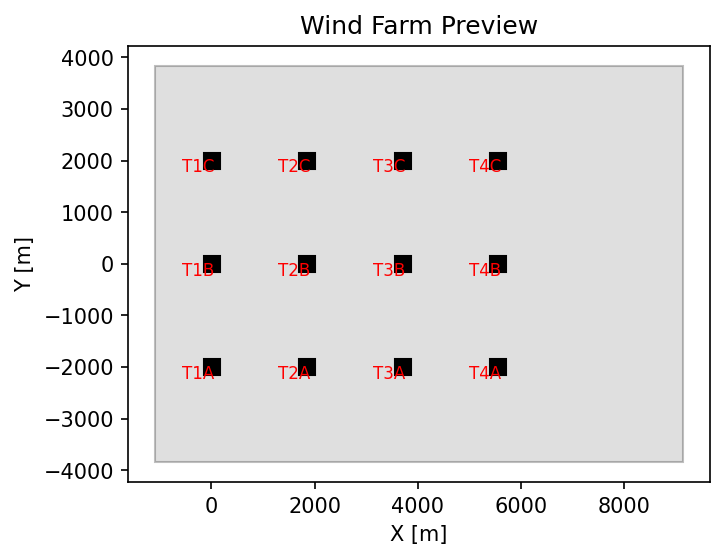

In [11]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

## Make refinement regions

In [12]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     750,    8000,      3000,  150,  500,      center:specified units:meter centerx:0 centery:0 centerz:150 name:Farm
1,  1,    1,    1,  1,  1.2, orientation:nacdir
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [13]:
case.refine_createAllZones()
# Print out existing list of refinement zones
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['Farm', 'T1A_level_1_zone', 'T2A_level_1_zone', 'T3A_level_1_zone', 'T4A_level_1_zone', 'T1B_level_1_zone', 'T2B_level_1_zone', 'T3B_level_1_zone', 'T4B_level_1_zone', 'T1C_level_1_zone', 'T2C_level_1_zone', 'T3C_level_1_zone', 'T4C_level_1_zone']


In [14]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     75497472             10.0 x 10.0 x 10.0
       1    273000000                5.0 x 5.0 x 5.0
       2     93428112                2.5 x 2.5 x 2.5
  TOTAL:    441925584


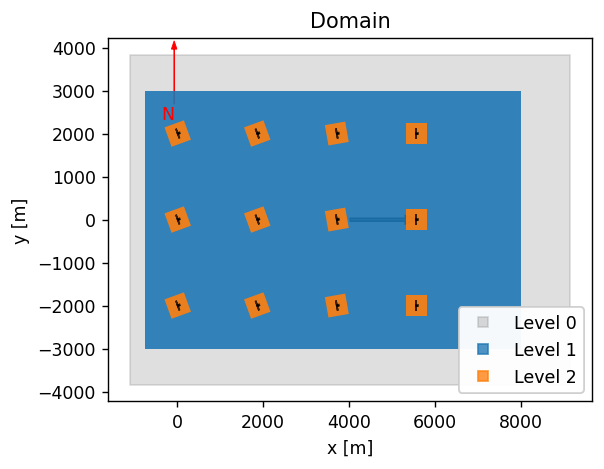

In [15]:
# Plot the domain
fig, ax2 = plt.subplots(figsize=(5,5), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.plotDomain(ax=ax2)

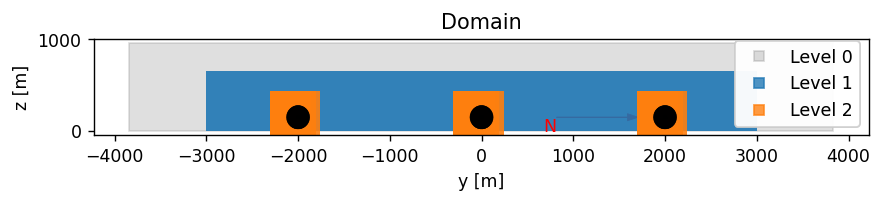

In [16]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

## Add sampling planes

In [17]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()
print(case.listboxpopupwindict['listboxsampling'].getitemlist())
print(case.listboxpopupwindict['listboxpostprosetup'].getitemlist())

[]
[]


In [18]:
# Set up averaging
pprosetup = case.get_default_postprosetupdict()
pprosetup['postprocessing_setup_name'] = 'sampling_'
pprosetup['postprocessing_setup_type'] = 'Sampling'
pprosetup['postprocessing_setup_output_frequency'] =  1000
pprosetup['postprocessing_setup_fields']           =  ['velocity', 'temperature','tke']
case.add_postprosetup(pprosetup, verbose=True)
sampleplane = case.get_default_samplingdict()
# Modify the geometry
sampleplane['sampling_name']         = 'XYslice'
sampleplane['sampling_outputto']     = 'sampling_'
sampleplane['sampling_type']         = 'PlaneSampler'
sampleplane['sampling_p_num_points'] = [1024, 768]
sampleplane['sampling_p_origin']     = [-1095., -3845., 0]
sampleplane['sampling_p_axis1']      = [1095+9145., 0, 0]
sampleplane['sampling_p_axis2']      = [0, 3845+3845, 0]
sampleplane['sampling_p_normal']     = [0, 0, 1]
sampleplane['sampling_p_offsets']    = '150.0'
case.add_sampling(sampleplane)

pprosetup = case.get_default_postprosetupdict()
pprosetup['postprocessing_setup_name'] = 'samplingxz_'
pprosetup['postprocessing_setup_type'] = 'Sampling'
pprosetup['postprocessing_setup_output_frequency'] =  1000
pprosetup['postprocessing_setup_fields']           =  ['velocity', 'temperature','tke']
case.add_postprosetup(pprosetup, verbose=True)
sampleplaneA = case.get_default_samplingdict()
sampleplaneA['sampling_name']         = 'XZslice'
sampleplaneA['sampling_outputto']     = 'samplingxz_'
sampleplaneA['sampling_type']         = 'PlaneSampler'
sampleplaneA['sampling_p_num_points'] = [1024, 96]
sampleplaneA['sampling_p_origin']     = [-1095., 0., 0]
sampleplaneA['sampling_p_axis1']      = [1095+9145., 0, 0]
sampleplaneA['sampling_p_axis2']      = [0, 0, 960]
sampleplaneA['sampling_p_normal']     = [0, 1, 0]
sampleplaneA['sampling_p_offsets']    = '-2000 0.0 2000'
case.add_sampling(sampleplaneA)

postprocessing_setup_name: 'sampling_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1000
postprocessing_setup_fields: ['velocity', 'temperature', 'tke']
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None
postprocessing_setup_name: 'samplingxz_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1000
postprocessing_setup_fields: ['velocity', 'temperature', 'tke']
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [19]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
rp1, rotorplane, 2,  8, 2, 0.6,  1,  101, 101, noffsets:11 outputto:RP_ outputfreq:10
sw1, streamwise, 2,  8, 0, 0.6,  1,  101, 101, outputto:SW_ outputfreq:10 orientation:275
#hh,  hubheight,2000,2000,960, 0,  none,  11, 11, usedx:10 units:meter center:farm orientation:x outputvars:velocity;tke;temperature outputfreq:10 outputto:hubheight_
"""

case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

In [20]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['XYslice', 'XZslice', 'T1A_rp1', 'T2A_rp1', 'T3A_rp1', 'T4A_rp1', 'T1B_rp1', 'T2B_rp1', 'T3B_rp1', 'T4B_rp1', 'T1C_rp1', 'T2C_rp1', 'T3C_rp1', 'T4C_rp1', 'T1A_sw1', 'T2A_sw1', 'T3A_sw1', 'T4A_sw1', 'T1B_sw1', 'T2B_sw1', 'T3B_sw1', 'T4B_sw1', 'T1C_sw1', 'T2C_sw1', 'T3C_sw1', 'T4C_sw1']


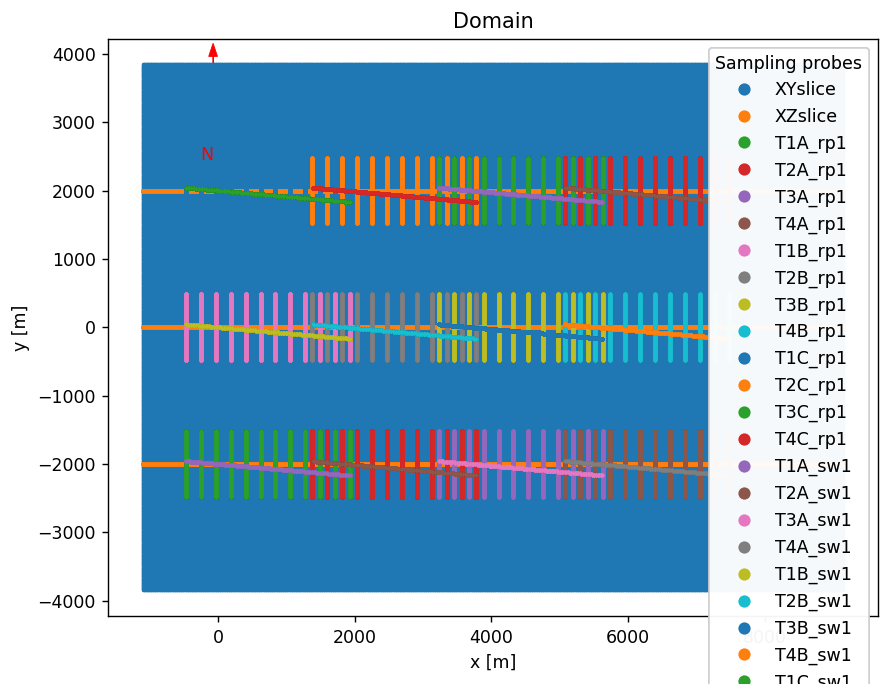

In [21]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

## Add some extra (manual) options

In [36]:
case.extradictparams['BodyForce.magnitude'] = '0.00045577915197378074 0.0009349589835232567 0.0'
case.extradictparams['TKE.interpolation'] = 'PiecewiseConstant'
case.extradictparams['nodal_proj.mg_rtol'] = 1.0e-6
case.extradictparams['nodal_proj.mg_atol'] = 1.0e-12
case.extradictparams['mac_proj.mg_rtol'] = 1.0e-6
case.extradictparams['mac_proj.mg_atol'] = 1.0e-12
case.extradictparams['diffusion.mg_rtol'] = 1.0e-6
case.extradictparams['diffusion.mg_atol'] = 1.0e-12
case.extradictparams['temperature_diffusion.mg_rtol'] = 1.0e-10
case.extradictparams['temperature_diffusion.mg_atol'] = 1.0e-13
case.extradictparams['io.outputs'] = 'actuator_src_term'
case.extradictparams['io.derived_outputs'] = 'q_criterion'
case.extradictparams['io.line_plot_int'] = 1
case.extradictparams['io.restart_file'] = chkdir

## Print the input file

In [37]:
# Write the input file
inputfile=case.writeAMRWindInput(outputfile)
if verbose: print(inputfile)

# --- Simulation time control parameters ---
time.stop_time                           = 21800.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.02                # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 1                   
io.check_file                            = chk                 
io.restart_file                          = ../02_precursor_shell/neutral_8.6at150.10dTInv_0.75z0_750zi_10x7x1km_feb3//chk40000/
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
nodal_proj.mg_rtol             

### Create a version without turbines

In [24]:
def removeturbines(runcase):
    physics = runcase.getAMRWindInput('incflo.physics')
    if 'Actuator' in physics:
        physics.remove('Actuator')
        runcase.setAMRWindInput('physics', physics)
        print('SET incflo.physics: '+repr(runcase.getAMRWindInput('incflo.physics')))
    runcase.setAMRWindInput('ActuatorForcing', False)    
    runcase.listboxpopupwindict['listboxactuator'].deleteall()
    return

In [25]:
#removeturbines(case)
#inputfile=case.writeAMRWindInput(noturboutputfile)
#if verbose: print(inputfile)